In [5]:
%matplotlib inline
import os
import sys
sys.path.append('/root/capsule/aind-beh-ephys-analysis/code/beh_ephys_analysis')
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from utils.beh_functions import session_dirs
from utils.plot_utils import shiftedColorMap, template_reorder, plot_raster_bar,merge_pdfs
from session_preprocessing import ephys_opto_preprocessing
from opto_tagging import opto_plotting_session
from open_ephys.analysis import Session
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
import pickle
import seaborn as sns

from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
# def load_motion_info(folder):
from spikeinterface.preprocessing.motion import load_motion_info

 
# Create a white-to-bright red colormap
colors = [(1, 1, 1), (1, 0, 0)]  # white to red
my_red = LinearSegmentedColormap.from_list("white_to_red", colors)

In [3]:
session = 'behavior_751004_2024-12-19_11-50-37'
session_dir = session_dirs(session)

behavior_751004_2024-12-19_11-50-37


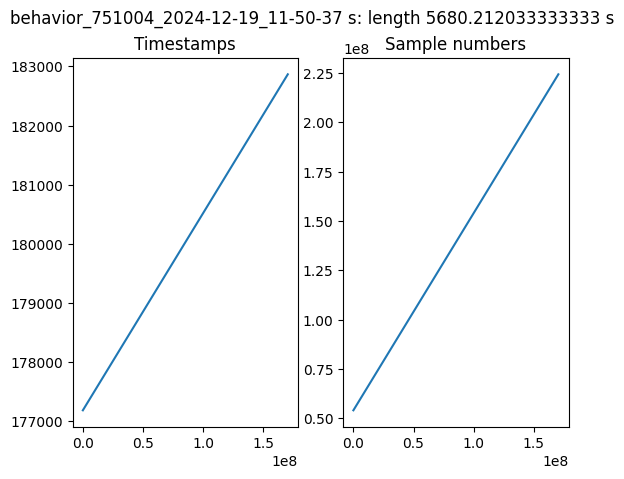

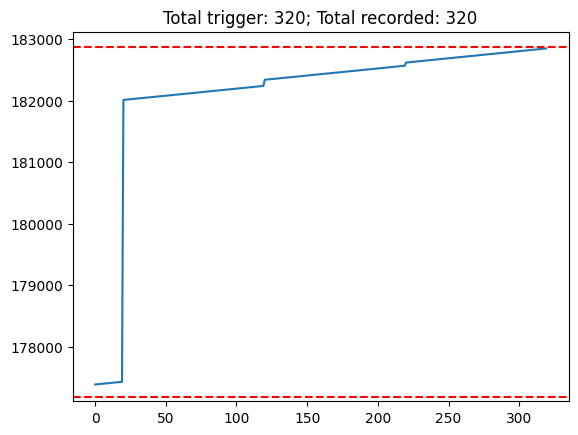

In [6]:
ephys_opto_preprocessing(session, 'curated', 'soma')

In [3]:
motion_info = load_motion_info(f'/root/capsule/data/{session}_sorted/preprocessed/motion/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1')

In [4]:
# fast dynamics
bin_short = 60
temp_bins = np.arange(motion_info['motion'].temporal_bins_s[0][0], motion_info['motion'].temporal_bins_s[0][-1], bin_short)
probe_location = np.linspace(motion_info['motion'].spatial_bins_um[-1],motion_info['motion'].spatial_bins_um[0],  96)

drift = np.zeros(shape=(len(probe_location), len(temp_bins)))
for i, t in enumerate(temp_bins): 
    for j, p in enumerate(probe_location):
        drift[j, i] = motion_info['motion'].get_displacement_at_time_and_depth([t], [p])

/tmp/ipykernel_3441/1795925088.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  drift[j, i] = motion_info['motion'].get_displacement_at_time_and_depth([t], [p])


In [96]:
# slow dynamics
bin_long = 300 # seconds
slow_first_ind = np.where(temp_bins >= temp_bins[0]+bin_long)[0][0]
temp_bins_slow = temp_bins[slow_first_ind:]

drift_slow = np.zeros(shape=(len(probe_location), len(temp_bins_slow)))
for i, t in enumerate(temp_bins_slow): 
    for j, p in enumerate(probe_location):
        drift_slow[j, i] = np.mean(drift[j, np.where((temp_bins >= t-bin_long-bin_short) & (temp_bins < t-bin_short))[0]])

Text(0.5, 1.0, 'Fast drift - slow drift')

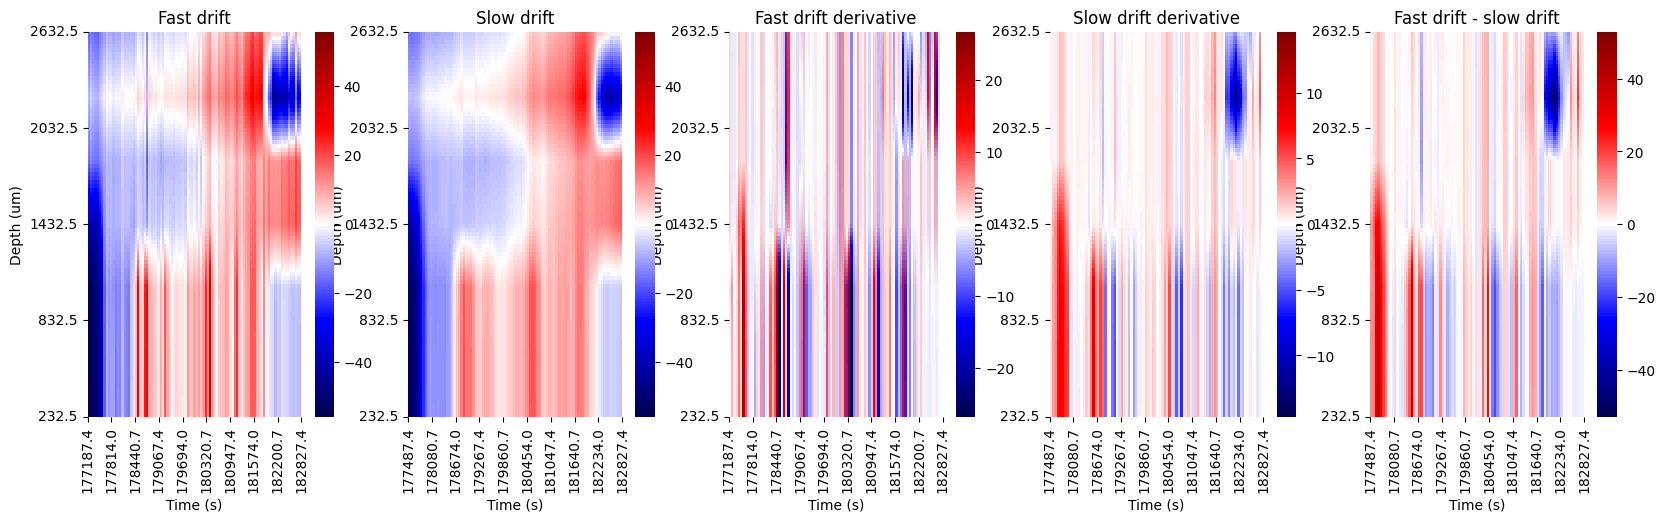

In [97]:
range_max = np.max(np.abs(drift))
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
plt.subplot(1, 5, 1)
sns.heatmap(drift, cmap='seismic', center=0, vmin=-range_max, vmax=range_max)
plt.xticks(np.linspace(0, len(temp_bins), 10), [f"{x:.1f}" for x in list(np.linspace(temp_bins[0], temp_bins[-1], 10))]);
plt.yticks(np.linspace(0, len(probe_location), 5), [f"{x:.1f}" for x in list(np.linspace(probe_location[0], probe_location[-1], 5))]);
plt.xlabel('Time (s)')
plt.ylabel('Depth (um)')
plt.title('Fast drift')

plt.subplot(1, 5, 2)
sns.heatmap(drift_slow, cmap='seismic', center=0, vmin=-range_max, vmax=range_max)
plt.xticks(np.linspace(0, len(temp_bins_slow), 10), [f"{x:.1f}" for x in list(np.linspace(temp_bins_slow[0], temp_bins_slow[-1], 10))]);
plt.yticks(np.linspace(0, len(probe_location), 5), [f"{x:.1f}" for x in list(np.linspace(probe_location[0], probe_location[-1], 5))]);
plt.xlabel('Time (s)')
plt.ylabel('Depth (um)')
plt.title('Slow drift')

plt.subplot(1, 5, 3)
range_max = np.max(np.abs(np.diff(drift)))
sns.heatmap(np.diff(drift), cmap='seismic', center=0, vmin=-range_max, vmax=range_max)
plt.xticks(np.linspace(0, len(temp_bins), 10), [f"{x:.1f}" for x in list(np.linspace(temp_bins[0], temp_bins[-1], 10))]);
plt.yticks(np.linspace(0, len(probe_location), 5), [f"{x:.1f}" for x in list(np.linspace(probe_location[0], probe_location[-1], 5))]);
plt.xlabel('Time (s)')
plt.ylabel('Depth (um)')
plt.title('Fast drift derivative')

range_max = np.max(np.abs(np.diff(drift_slow)))
plt.subplot(1, 5, 4)
sns.heatmap(np.diff(drift_slow), cmap='seismic', center=0, vmin=-range_max, vmax=range_max)
plt.xticks(np.linspace(0, len(temp_bins_slow), 10), [f"{x:.1f}" for x in list(np.linspace(temp_bins_slow[0], temp_bins_slow[-1], 10))]);
plt.yticks(np.linspace(0, len(probe_location), 5), [f"{x:.1f}" for x in list(np.linspace(probe_location[0], probe_location[-1], 5))]);
plt.xlabel('Time (s)')
plt.ylabel('Depth (um)')
plt.title('Slow drift derivative')

drift_diff = drift[:, slow_first_ind:] - drift_slow
range_max = np.max(np.abs(drift_diff))
plt.subplot(1, 5, 5)
sns.heatmap(drift_diff, cmap='seismic', center=0, vmin=-range_max, vmax=range_max)
plt.xticks(np.linspace(0, len(temp_bins_slow), 10), [f"{x:.1f}" for x in list(np.linspace(temp_bins_slow[0], temp_bins_slow[-1], 10))]);
plt.yticks(np.linspace(0, len(probe_location), 5), [f"{x:.1f}" for x in list(np.linspace(probe_location[0], probe_location[-1], 5))]);
plt.xlabel('Time (s)')
plt.ylabel('Depth (um)')
plt.title('Fast drift - slow drift')

In [9]:
unit_tbl = opto_plotting_session(session, 'raw', 'soma', plot=False, resp_thresh=0.3, lat_thresh=0.025) 

/root/capsule/code/beh_ephys_analysis/opto_tagging.py:347: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  unit_qc = unit_qc.apply(pd.to_numeric, errors='ignore')
/root/capsule/code/beh_ephys_analysis/opto_tagging.py:391: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  opto_wf = opto_wf.apply(pd.to_numeric, errors='ignore')


In [12]:
unit_tbl

,unit_id,resp_p,resp_lat,powers,sites,num_pulses,durations,freqs,stim_times,opto_pass,ks_unit_id,isi_violations_ratio,firing_rate,presence_ratio,amplitude_cutoff,decoder_label,depth,euclidean_norm,correlation,default_qc
0,0,None,None,None,None,None,None,None,None,False,0,0.000000,0.072709,0.808511,NaN,mua,170.43,NaN,NaN,False
1,1,None,None,None,None,None,None,None,None,False,1,0.486594,0.918804,0.872340,0.000383,mua,3.40,NaN,NaN,False
2,2,[0.72],[0.011866555440285469],[50],[surface_LC],[5],[5],[5],[post],True,2,0.048411,4.799117,1.000000,0.000168,sua,78.83,[0.009796584893414196],[0.9979699499820247],True
3,3,"[0.9, 0.9, 0.7, 0.65, 0.8]","[0.0108739817788934, 0.011918291425293622, 0.0...","[10, 20, 30, 40, 50]","[surface_LC, surface_LC, surface_LC, surface_L...","[5, 5, 5, 5, 5]","[4, 4, 4, 4, 4]","[5, 5, 5, 5, 5]","[post, post, post, post, post]",True,3,0.074913,10.321623,1.000000,0.000033,sua,94.24,"[0.02009094732387138, 0.020559034782977943, 0....","[0.9856545655365698, 0.9864406721741906, 0.984...",True
4,5,None,None,None,None,None,None,None,None,False,5,0.000326,60.011850,1.000000,0.000288,sua,160.25,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,291,None,None,None,None,None,None,None,None,False,291,0.445746,0.362839,0.712766,0.001617,sua,1455.97,NaN,NaN,False
267,292,None,None,None,None,None,None,None,None,False,292,0.000000,1.214215,0.989362,0.000188,sua,1479.06,NaN,NaN,True
268,293,None,None,None,None,None,None,None,None,False,293,0.000000,0.107742,1.000000,0.006235,sua,1493.44,NaN,NaN,True
269,294,"[0.7, 0.9]","[0.00600609941354308, 0.005745330289106018]","[40, 50]","[surface_LC, surface_LC]","[5, 5]","[4, 4]","[5, 5]","[post, post]",True,294,109.937804,0.146121,0.287234,0.039867,noise,708.71,"[0.026763981711931433, 0.02543098843437621]","[0.2749530729868739, 0.6094439398293118]",False


In [18]:
sorting_analyzer = si.load_sorting_analyzer(session_dir['postprocessed_dir_curated']) 

In [15]:
sorting = si.load_extractor(session_dir['curated_dir_curated'])

In [29]:
unit_locations = sorting_analyzer.get_extension('unit_locations').get_data(outputs="by_unit")
spike_amplitude = sorting_analyzer.get_extension('spike_amplitudes').get_data(outputs="by_unit")[0]

In [30]:
spike_amplitude

{0: array([-1.51514984e+02, -1.19924995e+02, -1.95389984e+02,  1.12319992e+02,
        -3.28184998e+02, -2.09429993e+02, -5.90849991e+01, -2.63834991e+02,
        -3.04200012e+02, -3.33449982e+02, -1.03544998e+02, -3.46320007e+02,
         9.88649979e+01, -2.39850006e+01,  8.83349991e+01, -8.36549988e+01,
        -2.82554993e+02,  7.19549942e+01, -3.23505005e+02, -2.08844986e+02,
        -6.49349976e+01, -7.66349945e+01, -1.81934982e+02, -7.83899994e+01,
        -2.62665009e+02, -3.23505005e+02, -9.30149994e+01, -8.18999958e+00,
        -2.76119995e+02, -3.31695007e+02,  6.08399963e+01,  9.65249939e+01,
        -3.19410004e+02,  9.30149994e+01, -2.97179993e+02, -3.71475006e+02,
         1.32210007e+02, -2.60910004e+02, -1.34549990e+01, -3.37544983e+02,
        -1.97144989e+02, -5.96699982e+01, -3.92535004e+02, -1.62044983e+02,
        -4.15934998e+02, -1.76084991e+02, -4.46354980e+02, -4.63904999e+02,
        -2.10599991e+02,  1.11149998e+01, -4.62734985e+02,  1.51514999e+02,
        -